# APS PMDI canister fluorescence : BaSO4 suspensions

Post processing of X-ray canister fluorescence data with BaSO4 surrogate suspensions.
Fifth step - Apply signal trapping corrections to different scans and produce usable graphs.

Data collected by Daniel Duke, Lingzhe Rao & Alan Kastengren
@ Advanced Photon Source, Argonne National Laboratory, Lemont, Illinois USA
November, 2022.

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2022 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 20/03/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [340]:
import h5py, glob, copy, os
import numpy as np
import scipy.optimize, scipy.integrate, scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

# Get my functions from the last two notebooks, which are saved into a Python module.
from dd_xrf_functions import *
from dd_xrf_sigtrap import *

# BaSO4 horizontal scans

Each scan is vs time and one positioner (X or Y). The repeated scans are after a certain # of actuations fired.

In [341]:
dataB={}
for propellant in ['134','152','1234']:
    
    # KI solution in ethanol
    filenames = glob.glob('%s BaSO4 Canister*.h5' % propellant)
    
    for filename in filenames:
        for scanType in ['VerticalScans','HorizontalScans']:
        
            fluorLine='Ba Ka'

            with h5py.File(filename,'r') as H:
                if scanType in H:
                    scans = list(H['%s/x' % scanType].keys())
                    print(filename)
                    for s in scans:
                        x = H['%s/x/%s' % (scanType,s)][...]
                        y = H['%s/y/%s' % (scanType,s)][...]
                        t = H['%s/shakeTimer/%s' % (scanType,s)][...]
                        t2 = H['%s/shotCounter/%s' % (scanType,s)][...]
                        zF = H['%s/%s/integral/%s' % (scanType,fluorLine,s)][...]
                        I0 = H['%s/diamondMonitor/%s' % (scanType,s)][...]
                        zP = H['%s/pinDiode/%s' % (scanType,s)][...]

                        pinDiode = -np.log(zP/I0)
                        if propellant == '1234': prop='1234E'
                        else: prop=propellant

                        signalTrappingCorrection, rhoFluid = applySignalTrapping(x,y,zF,zP,I0,prop,\
                                                                                 ethMassFrac=0,tracer='Ba')
                        zF_corr = zF / signalTrappingCorrection

                        key = '%s %s %s' % (os.path.splitext(filename)[0],scanType,s)
                        print(" -> ",key)
                        dataB[key] = {'x':x, 'y':y, 't':t, 'pinDiode':pinDiode, 'I0':I0,\
                              'fluor':zF, 'fluorCorr':zF_corr, 'rhoFluid':rhoFluid, 'propellant':propellant,\
                               'shotCounter':t2}

134 BaSO4 Canister 7.h5
 ->  134 BaSO4 Canister 7 HorizontalScans Scan_4314
 ->  134 BaSO4 Canister 7 HorizontalScans Scan_4315
 ->  134 BaSO4 Canister 7 HorizontalScans Scan_4316
 ->  134 BaSO4 Canister 7 HorizontalScans Scan_4317
134 BaSO4 Canister 8.h5
 ->  134 BaSO4 Canister 8 HorizontalScans Scan_4344
 ->  134 BaSO4 Canister 8 HorizontalScans Scan_4345
 ->  134 BaSO4 Canister 8 HorizontalScans Scan_4346
 ->  134 BaSO4 Canister 8 HorizontalScans Scan_4347
 ->  134 BaSO4 Canister 8 HorizontalScans Scan_4348
134 BaSO4 Canister 5.h5
 ->  134 BaSO4 Canister 5 VerticalScans Scan_4286
 ->  134 BaSO4 Canister 5 VerticalScans Scan_4287
 ->  134 BaSO4 Canister 5 VerticalScans Scan_4288
 ->  134 BaSO4 Canister 5 VerticalScans Scan_4289
 ->  134 BaSO4 Canister 5 VerticalScans Scan_4290
 ->  134 BaSO4 Canister 5 VerticalScans Scan_4291
 ->  134 BaSO4 Canister 5 VerticalScans Scan_4292
 ->  134 BaSO4 Canister 5 VerticalScans Scan_4293
152 BaSO4 Canister 10.h5
 ->  152 BaSO4 Canister 10 Vertical

In [342]:
# Manual corrections to shot counter
for k in dataB:

    if ('Scan_4315' in k):
        dataB[k]['shotCounter'][...] = 55
    elif ('Scan_4316' in k):
        dataB[k]['shotCounter'][...] = 105
    elif ('Scan_4317' in k):
        dataB[k]['shotCounter'][...] = 155
    elif ('Scan_4344' in k):
        dataB[k]['shotCounter'][...] = 5
    elif ('Scan_4345' in k):
        dataB[k]['shotCounter'][...] = 55
    elif ('Scan_4346' in k):
        dataB[k]['shotCounter'][...] = 55
    elif ('Scan_4347' in k):
        dataB[k]['shotCounter'][...] = 105
    elif ('Scan_4348' in k):
        dataB[k]['shotCounter'][...] = 105
    elif ('Scan_4286' in k):
        dataB[k]['shotCounter'][...] = 5
    elif ('Scan_4287' in k):
        dataB[k]['shotCounter'][...] = 5
    elif ('Scan_4363' in k):
        dataB[k]['shotCounter'][...] = 5
    elif ('Scan_4364' in k):
        dataB[k]['shotCounter'][...] = 5
    elif ('Scan_4365' in k):
        dataB[k]['shotCounter'][...] = 55
    elif ('Scan_4366' in k):
        dataB[k]['shotCounter'][...] = 55
    elif ('Scan_4341' in k):
        dataB[k]['shotCounter'][...] = 105
    elif ('Scan_4342' in k):
        dataB[k]['shotCounter'][...] = 105
    elif ('Scan_4323' in k):
        dataB[k]['shotCounter'][...] = 5
    elif ('Scan_4325' in k):
        dataB[k]['shotCounter'][...] = 105
    elif ('Scan_4326' in k):
        dataB[k]['shotCounter'][...] = 155
    elif ('Scan_4328' in k):
        dataB[k]['shotCounter'][...] = 205
    elif ('Scan_4294' in k):
        dataB[k]['shotCounter'][...] = 5
    elif ('Scan_4302' in k):
        dataB[k]['shotCounter'][...] = 5
    elif ('Scan_4303' in k):
        dataB[k]['shotCounter'][...] = 55
    elif ('Scan_4305' in k):
        dataB[k]['shotCounter'][...] = 105
    elif ('Scan_4306' in k):
        dataB[k]['shotCounter'][...] = 155
    elif ('Scan_4307' in k):
        dataB[k]['shotCounter'][...] = 155
    elif ('Scan_4308' in k):
        dataB[k]['shotCounter'][...] = 155
    elif ('Scan_4310' in k):
        dataB[k]['shotCounter'][...] = 205
    elif ('Scan_4311' in k):
        dataB[k]['shotCounter'][...] = 255
    print(k, '\t',dataB[k]['shotCounter'].min(), dataB[k]['shotCounter'].max())

134 BaSO4 Canister 7 HorizontalScans Scan_4314 	 5.0 5.0
134 BaSO4 Canister 7 HorizontalScans Scan_4315 	 55.0 55.0
134 BaSO4 Canister 7 HorizontalScans Scan_4316 	 105.0 105.0
134 BaSO4 Canister 7 HorizontalScans Scan_4317 	 155.0 155.0
134 BaSO4 Canister 8 HorizontalScans Scan_4344 	 5.0 5.0
134 BaSO4 Canister 8 HorizontalScans Scan_4345 	 55.0 55.0
134 BaSO4 Canister 8 HorizontalScans Scan_4346 	 55.0 55.0
134 BaSO4 Canister 8 HorizontalScans Scan_4347 	 105.0 105.0
134 BaSO4 Canister 8 HorizontalScans Scan_4348 	 105.0 105.0
134 BaSO4 Canister 5 VerticalScans Scan_4286 	 5.0 5.0
134 BaSO4 Canister 5 VerticalScans Scan_4287 	 5.0 5.0
134 BaSO4 Canister 5 VerticalScans Scan_4288 	 25.0 25.0
134 BaSO4 Canister 5 VerticalScans Scan_4289 	 50.0 50.0
134 BaSO4 Canister 5 VerticalScans Scan_4290 	 100.0 100.0
134 BaSO4 Canister 5 VerticalScans Scan_4291 	 100.0 150.0
134 BaSO4 Canister 5 VerticalScans Scan_4292 	 150.0 200.0
134 BaSO4 Canister 5 VerticalScans Scan_4293 	 200.0 200.0
152 B

## Ensemble-average repeated data

In [481]:
kPrev = None
removeList = []
newMergedScans = {}
for k in dataB:
    if kPrev is not None:
        if kPrev.split('Scan_')[0] in k: # if same canister and scan type
            s=np.nanmax(dataB[k]['shotCounter'])
            sPrev=np.nanmax(dataB[kPrev]['shotCounter'])
            if s==sPrev: # if shot counter unchanged as well
                if(len(dataB[k]['x'].shape) == len(dataB[kPrev]['x'].shape)): # If same dimensionality
                
                    print(k,dataB[k]['x'].shape,'&',kPrev,dataB[kPrev]['x'].shape)
                
                    yvar = 't'
                    if 'HorizontalScans' in k: xvar='x'
                    else: xvar='y'
                
                    newData={}
                    xp = np.unique(np.round(np.concatenate((dataB[k][xvar].ravel(), dataB[kPrev][xvar].ravel())),3))
                    yp = np.unique(np.round(np.concatenate((dataB[k][yvar].ravel(), dataB[kPrev][yvar].ravel())),3))
                    x,y = np.meshgrid(xp,yp)
                    
                    pts = [(x.ravel()[n], y.ravel()[n]) for n in np.arange(np.product(x.shape))]

                    for j in dataB[k]:
                        if not isinstance(dataB[k][j],np.ndarray):
                            newData[j] = copy.deepcopy(dataB[k][j])
                        else:
                            #print('\t',j,np.nanmin(dataB[k][j]), np.nanmin(dataB[kPrev][j]))
                            #print('\t',dataB[k][j].shape, dataB[kPrev][j].shape)

                            # interpolate them together and average at matched x,y grid.
                            x_ = dataB[k][xvar].ravel()
                            y_ = dataB[k][yvar].ravel()
                            z_ = dataB[k][j].ravel()
                            L1=scipy.interpolate.NearestNDInterpolator([(x_[n], y_[n]) for n in range(len(x_))], z_)

                            x_ = dataB[kPrev][xvar].ravel()
                            y_ = dataB[kPrev][yvar].ravel()
                            z_ = dataB[kPrev][j].ravel()
                            L2=scipy.interpolate.NearestNDInterpolator([(x_[n], y_[n]) for n in range(len(x_))], z_)

                            newData[j] = np.nan_to_num(L1(pts)) + np.nan_to_num(L2(pts))
                            newData[j] = newData[j].reshape(x.shape)
                    print("\t->",newData[j].shape)

                    # write new dict entry and remove old
                    newMergedScans['%s_and_%s' % (k,kPrev.split('Scan_')[1])] = newData
                    removeList.extend((k,kPrev))

    kPrev=k

print("\nCREATED: ",newMergedScans.keys())

134 BaSO4 Canister 5 VerticalScans Scan_4287 (60, 6) & 134 BaSO4 Canister 5 VerticalScans Scan_4286 (80, 7)
	-> (916, 8)
134 BaSO4 Canister 5 VerticalScans Scan_4293 (50, 7) & 134 BaSO4 Canister 5 VerticalScans Scan_4292 (50, 7)
	-> (694, 7)
152 BaSO4 Canister 9 HorizontalScans Scan_4339 (50, 7) & 152 BaSO4 Canister 9 HorizontalScans Scan_4336 (50, 7)
	-> (700, 7)
152 BaSO4 Canister 7 VerticalScans Scan_4300 (50, 7) & 152 BaSO4 Canister 7 VerticalScans Scan_4299 (50, 7)
	-> (689, 7)
1234 BaSO4 Canister 11 VerticalScans Scan_4307 (50, 7) & 1234 BaSO4 Canister 11 VerticalScans Scan_4306 (50, 7)
	-> (526, 8)
1234 BaSO4 Canister 11 VerticalScans Scan_4308 (50, 7) & 1234 BaSO4 Canister 11 VerticalScans Scan_4307 (50, 7)
	-> (421, 8)

CREATED:  dict_keys(['134 BaSO4 Canister 5 VerticalScans Scan_4287_and_4286', '134 BaSO4 Canister 5 VerticalScans Scan_4293_and_4292', '152 BaSO4 Canister 9 HorizontalScans Scan_4339_and_4336', '152 BaSO4 Canister 7 VerticalScans Scan_4300_and_4299', '1234 BaSO

In [482]:
# Get final data
print("Starting with %i scans" % len(dataB.keys()))
data = copy.deepcopy(newMergedScans)
for k in dataB:
    if not k in removeList:
        data[k]=dataB[k]
print("Using %i scans" % len(data.keys()))
for k in data: print(k)

Starting with 47 scans
Using 42 scans
134 BaSO4 Canister 5 VerticalScans Scan_4287_and_4286
134 BaSO4 Canister 5 VerticalScans Scan_4293_and_4292
152 BaSO4 Canister 9 HorizontalScans Scan_4339_and_4336
152 BaSO4 Canister 7 VerticalScans Scan_4300_and_4299
1234 BaSO4 Canister 11 VerticalScans Scan_4307_and_4306
1234 BaSO4 Canister 11 VerticalScans Scan_4308_and_4307
134 BaSO4 Canister 7 HorizontalScans Scan_4314
134 BaSO4 Canister 7 HorizontalScans Scan_4315
134 BaSO4 Canister 7 HorizontalScans Scan_4316
134 BaSO4 Canister 7 HorizontalScans Scan_4317
134 BaSO4 Canister 8 HorizontalScans Scan_4344
134 BaSO4 Canister 8 HorizontalScans Scan_4345
134 BaSO4 Canister 8 HorizontalScans Scan_4346
134 BaSO4 Canister 8 HorizontalScans Scan_4347
134 BaSO4 Canister 8 HorizontalScans Scan_4348
134 BaSO4 Canister 5 VerticalScans Scan_4288
134 BaSO4 Canister 5 VerticalScans Scan_4289
134 BaSO4 Canister 5 VerticalScans Scan_4290
134 BaSO4 Canister 5 VerticalScans Scan_4291
152 BaSO4 Canister 10 Vertica

In [535]:
# Add calibration constant
for k in data:
    can = k.split(' ')[0] + ' ' + k.split(' ')[3]
    if can == '134 5':  mgPerMl=2.031935023
    elif can == '134 7': mgPerMl=1.980974346
    elif can == '134 8': mgPerMl=1.964511478
    elif can == '152 7': mgPerMl=1.907710075
    elif can == '152 8': mgPerMl=1.895996174
    elif can == '152 9': mgPerMl=1.928946645
    elif can == '152 10': mgPerMl=1.914201976
    elif can == '1234 11': mgPerMl=2.021622565
    elif can == '1234 12': mgPerMl=2.013647655
    elif can == '1234 13': mgPerMl=2.018068088
    else: raise keyError("unknown canister")
   
    data[k]['calibrationConstant'] = 6000./(mgPerMl*11.5*2)

## Radial (horizontal) scans

X range -19.999981 - 0.000000 mm



<IPython.core.display.Javascript object>


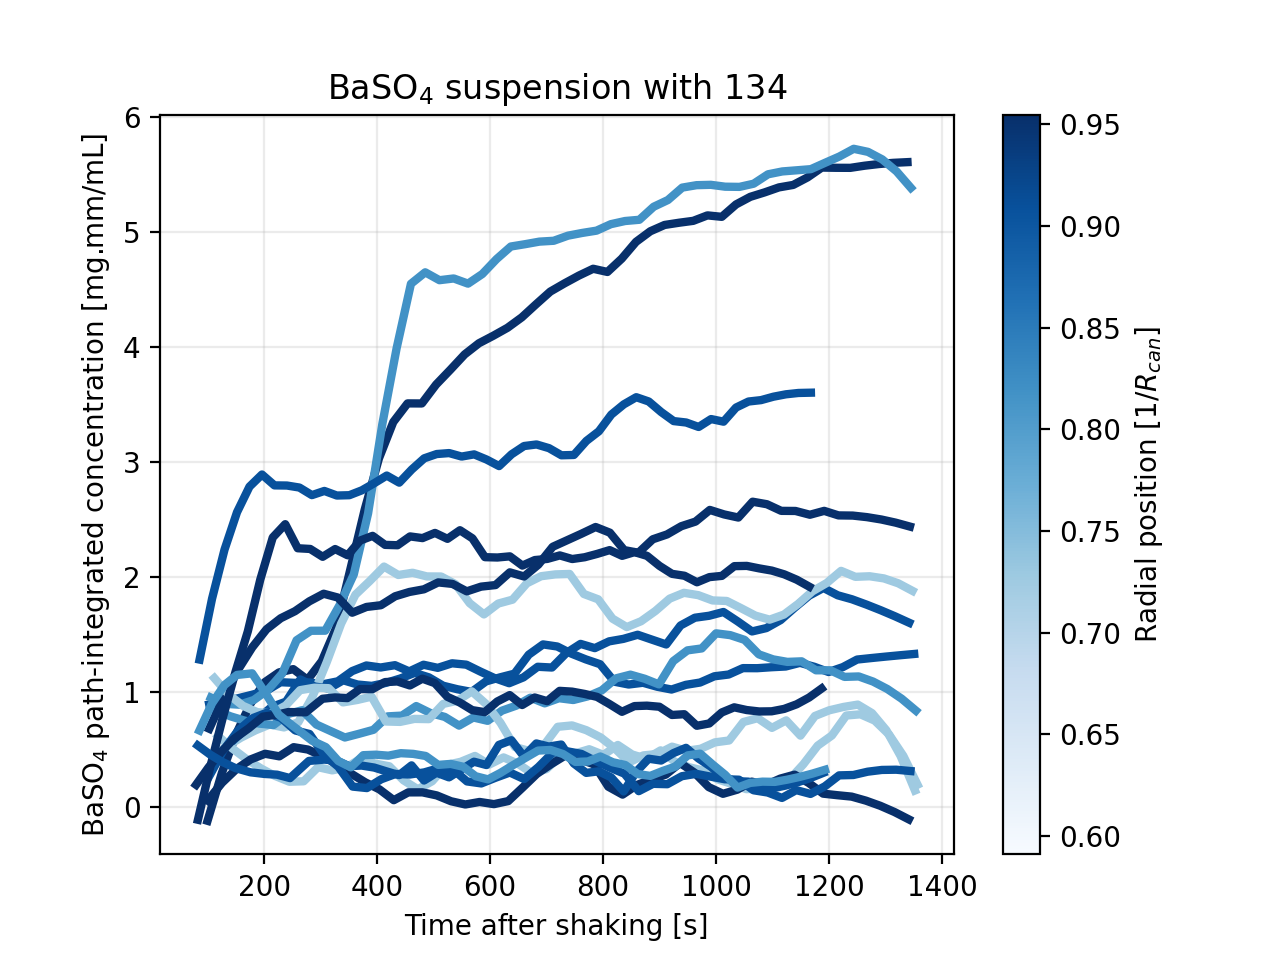

<IPython.core.display.Javascript object>


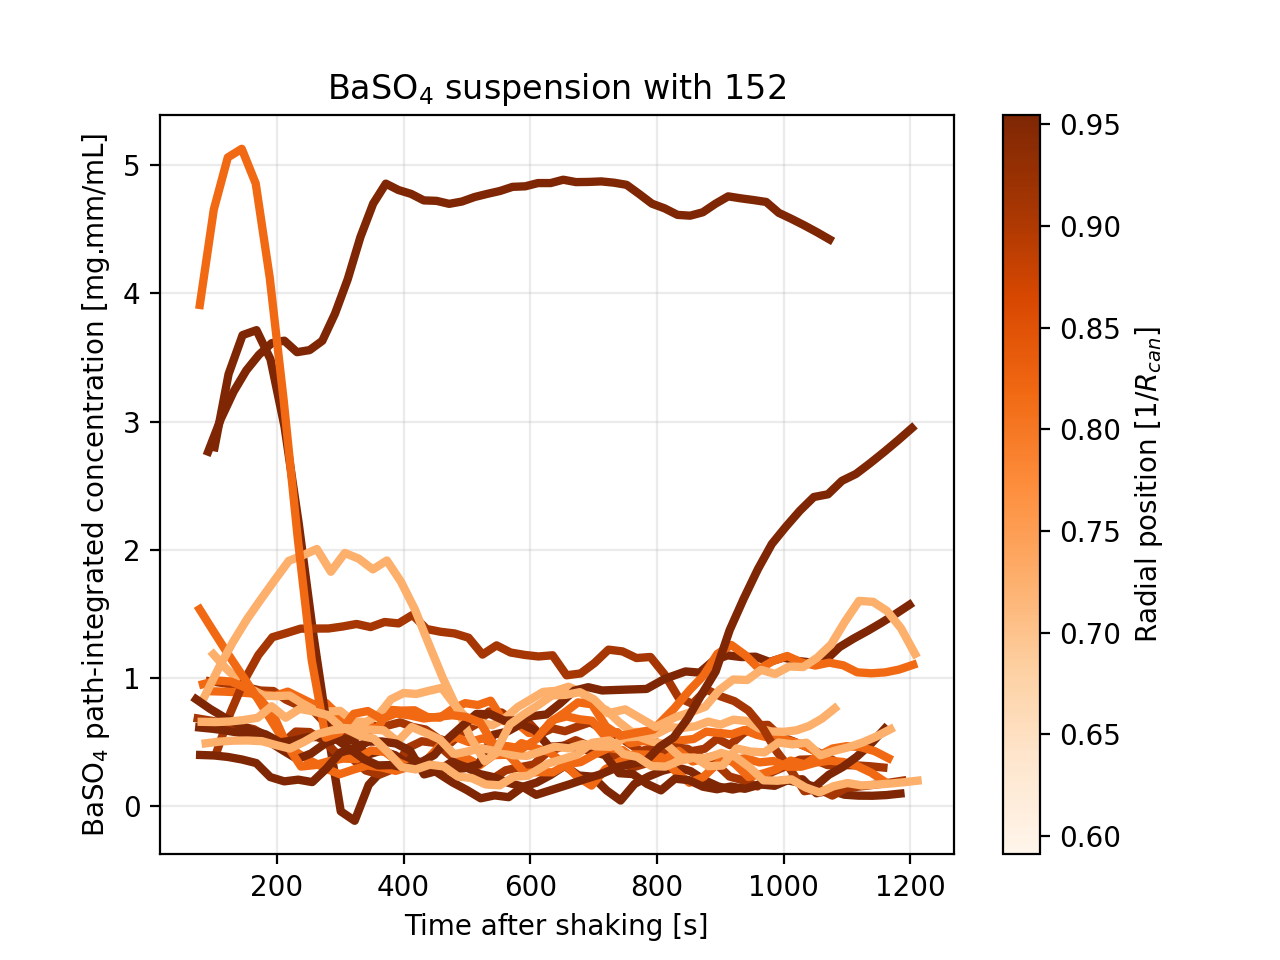

<IPython.core.display.Javascript object>


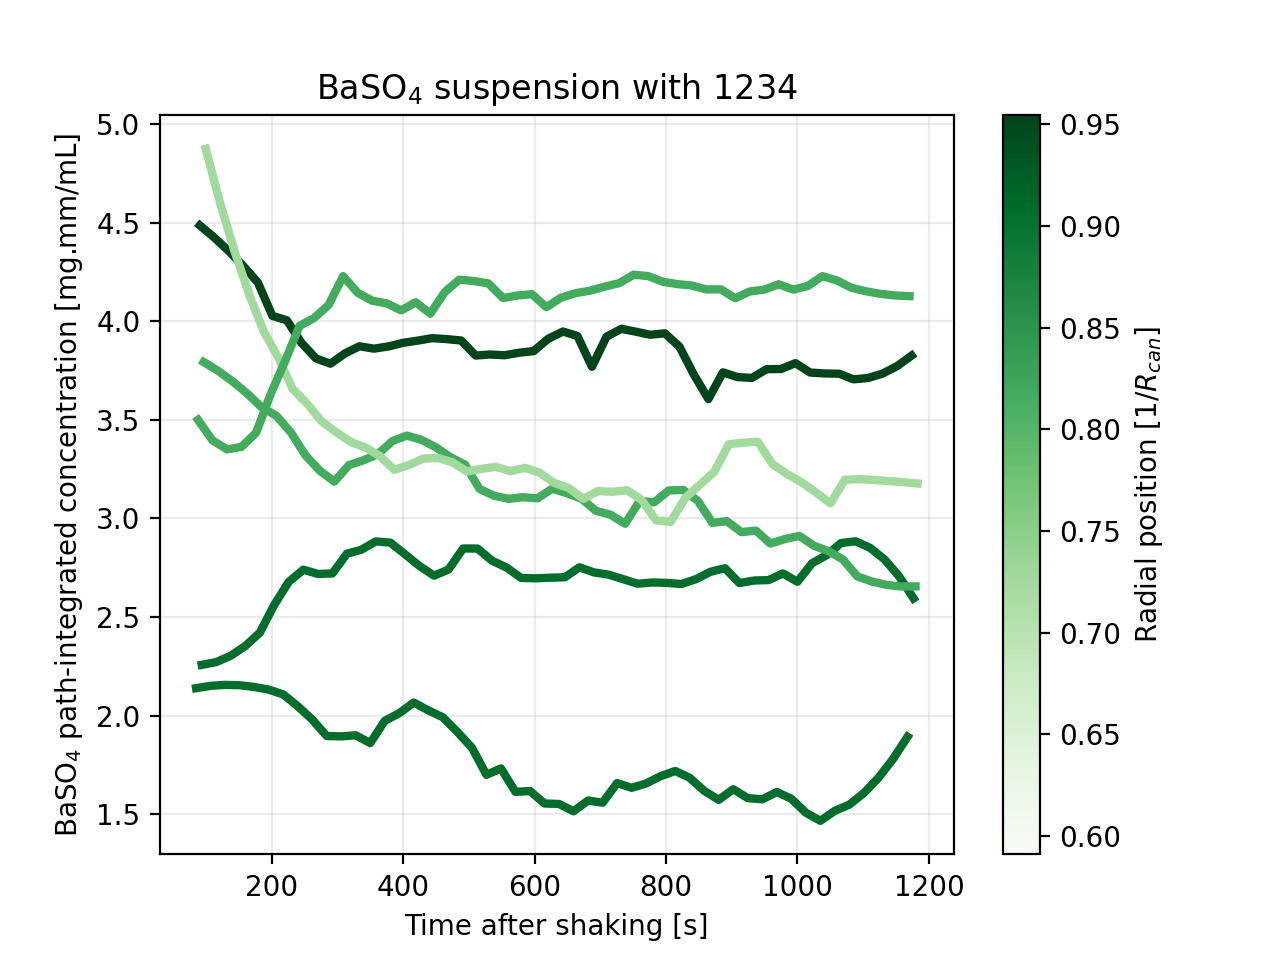

In [536]:
# Extract one X position and plot against time for each scan.

#min,max radius values to consider 
selectX = (-8,-5)

# Get all possible X values.
allX = np.concatenate([data[k]['x'].ravel() for k in data if 'HorizontalScans' in k])
print("X range %f - %f mm\n" % (allX.min(),allX.max()))

# Function to apply calibration to data or normalize it
def applyCal(z,calibrationConstant):
    offset=0.
    norm=1.
    # fix anonymously large values (ie scatter off the nozzle wall causes constant offset in signal.)
    if np.nanmean(z[-5:]) > 1500: norm = np.nan #offset = 1100
    return (z-offset) / calibrationConstant / norm

# Function to define if a scan is worth plotting (empty,flat or not)
def usable(z,prop):
    #if '1234' in prop: threshold=0
    pp = np.nanmean(z[:5]) - np.nanmean(z[-5:])
    if np.abs(pp) > 25: return True
    return False

# Smoothing function
from scipy.signal import savgol_filter
def smooth(x,ww=9,order=2):
    if(len(x)<=ww): return x
    return savgol_filter(x, ww, order)

# Colormap selection based on propellant
def selectcmap(prop):
    if '134' in prop: return plt.cm.Blues_r
    elif '152' in prop: return plt.cm.Oranges_r
    elif '1234' in prop: return plt.cm.Greens_r
    else: raise ValueError("Invalid propellant")

# Colour function
def cfun(x, prop):
    xNorm = (np.median(x) - selectX[0] - 0.5)/(selectX[1]-selectX[0]+0.5*2)
    #xNorm = np.nanmax(x)/255.
    return selectcmap(prop)(xNorm * (xNorm<=1) + (xNorm > 1))
    
# Linewidth function
def lfun(x):
    return 3. #np.round(np.nanmean(x)/50.,0)+1
    
# Loop propellants
for prop in ['134','152','1234']:
    
    # Make figure
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.grid(alpha=.25)
    plt.xlabel('Time after shaking [s]')
    plt.ylabel('BaSO$_4$ path-integrated concentration [mg.mm/mL]')
    lList = ['-','--','-.','-','--','-.','-','--','-.']
    plt.title('BaSO$_4$ suspension with %s' % prop)
    # Search all data
    for k in data:
        
        # Show only those which are H scans with correct propellant
        if ('HorizontalScans' in k) and (prop in k):
            
            # Get data and make label
            t = data[k]['t']
            s = data[k]['shotCounter']
            x = data[k]['x']
            y = yTransform(data[k]['y'])
            prop=data[k]['propellant']
            cc=data[k]['calibrationConstant']
            z = copy.deepcopy(data[k]['fluorCorr']) 
            kk = k.replace('HorizontalScans','').replace('VerticalScans','').replace('Canister','can')
            kk = kk.split('Scan_')[0]

            if ((len(t.shape)>1) and (t.shape[0]>1)): # 2D matrix
                flt = np.unique(np.where( (x>=selectX[0])&(x<=selectX[1]) )[1])
                for i in flt:
                    xval = np.median(x[:,i])
                    if ((xval>=selectX[0]) & (xval<=selectX[1])):
                        label = kk+' X=%.2f'% xval
                        if usable(z[:,i],prop):
                            ax.plot(t[:,i], applyCal(smooth(z[:,i]),cc), label=label, c=cfun(xval,prop),lw=lfun(s))

            elif (len(t.shape)==1): # 1D vector
                # Filter on X position
                validX = np.unique(np.round(x[(x>=selectX[0])&(x<=selectX[1])],3))
                for xval in validX:
                    i = validX==xval
                    label = kk+' X=%.2f *'% xval
                    flt = np.where( np.abs(x-xval) < 1e-2 )[0]
                    if(np.any(flt)):
                        if usable(z[flt],prop):
                            ax.plot(t[flt],applyCal(smooth(z[flt]),cc),label=label, c=cfun(xval,prop),lw=lfun(s))

            else:
                raise RuntimeError(k)

    # Make colorbar. We need to reverse the direction because the values are negative.
    # Doing this only flips the colorbar direction , not the data itself.
    # From the expeiment we know the can wall was not at R=0 in these measurements due to the shaking rig
    # setup hack (the pneumatic rig didn't arrive in time, it was hand-shaken). So need to adjust offset X.
    if '134' in prop: cmap = plt.cm.Blues
    elif '152' in prop: cmap = plt.cm.Oranges
    elif '1234' in prop: cmap = plt.cm.Greens
    offsetX = 2.0
    vmin = (selectX[0] - 0.5 - offsetX)/11.
    vmax = (selectX[1] + 0.5 - offsetX)/11.
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=-vmax,vmax=-vmin))
    #sm = plt.cm.ScalarMappable(cmap=selectcmap(prop),norm=plt.Normalize(vmin=vmin,vmax=vmax))
    plt.colorbar(sm,ax=ax,label='Radial position [1/$R_{can}$]')            
    
    #ax.legend();#bbox_to_anchor=(1.5, 1),fontsize=8);
        
        
        

## Vertical (axial) scans

Y range -75.000000 - 75.000000 mm



<IPython.core.display.Javascript object>


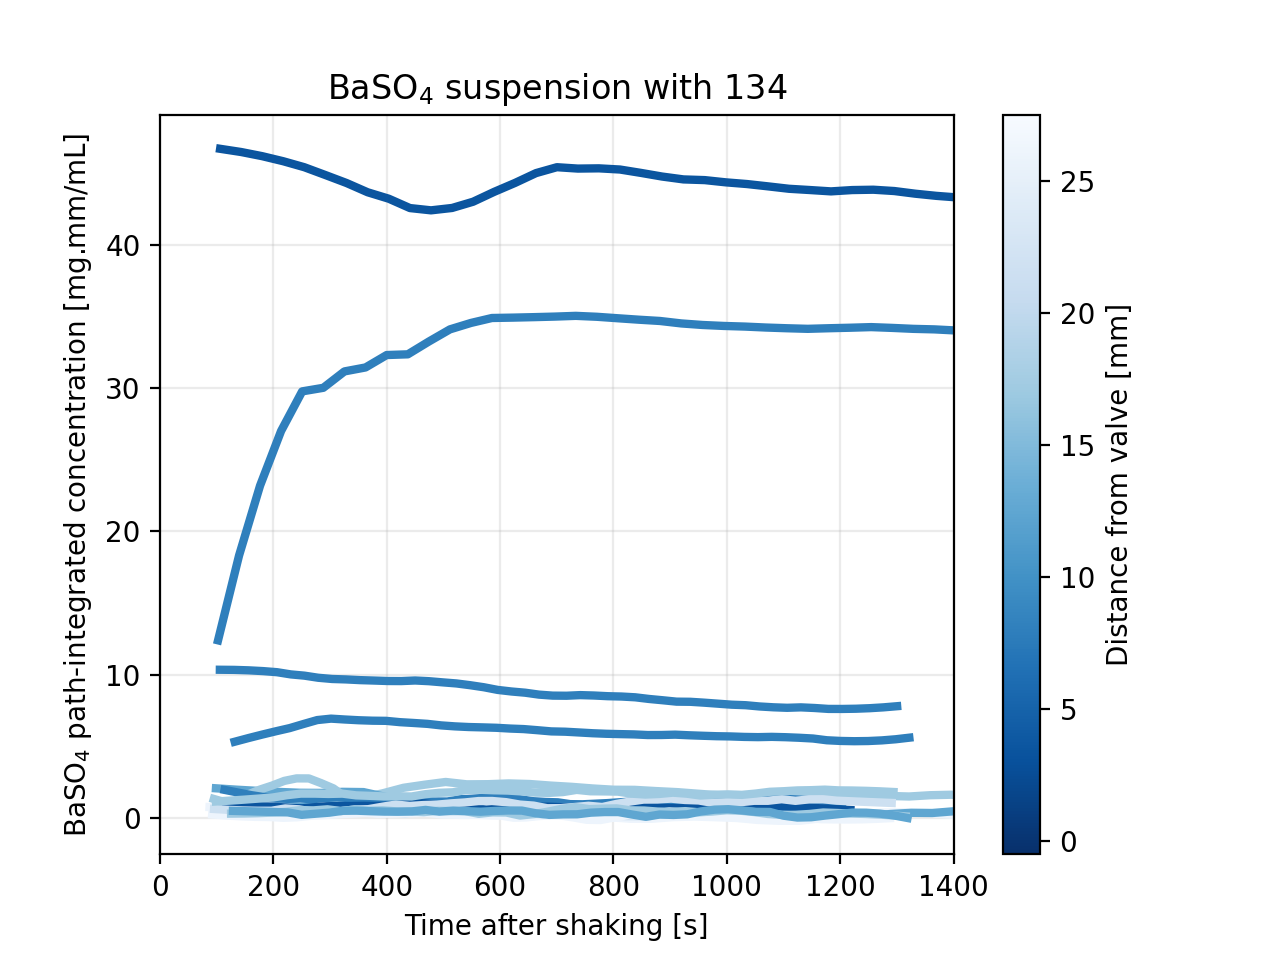

<IPython.core.display.Javascript object>


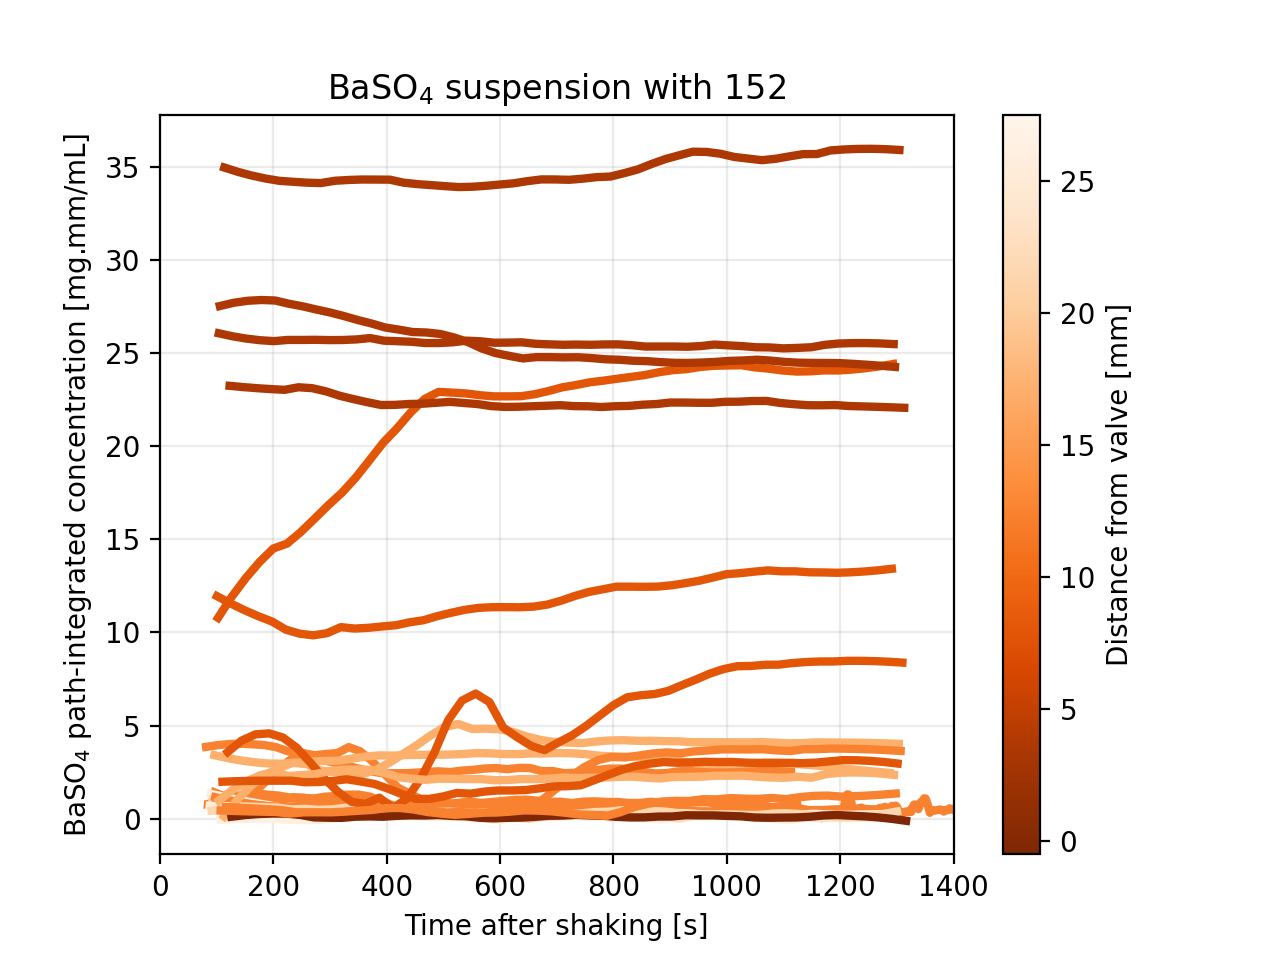

<IPython.core.display.Javascript object>


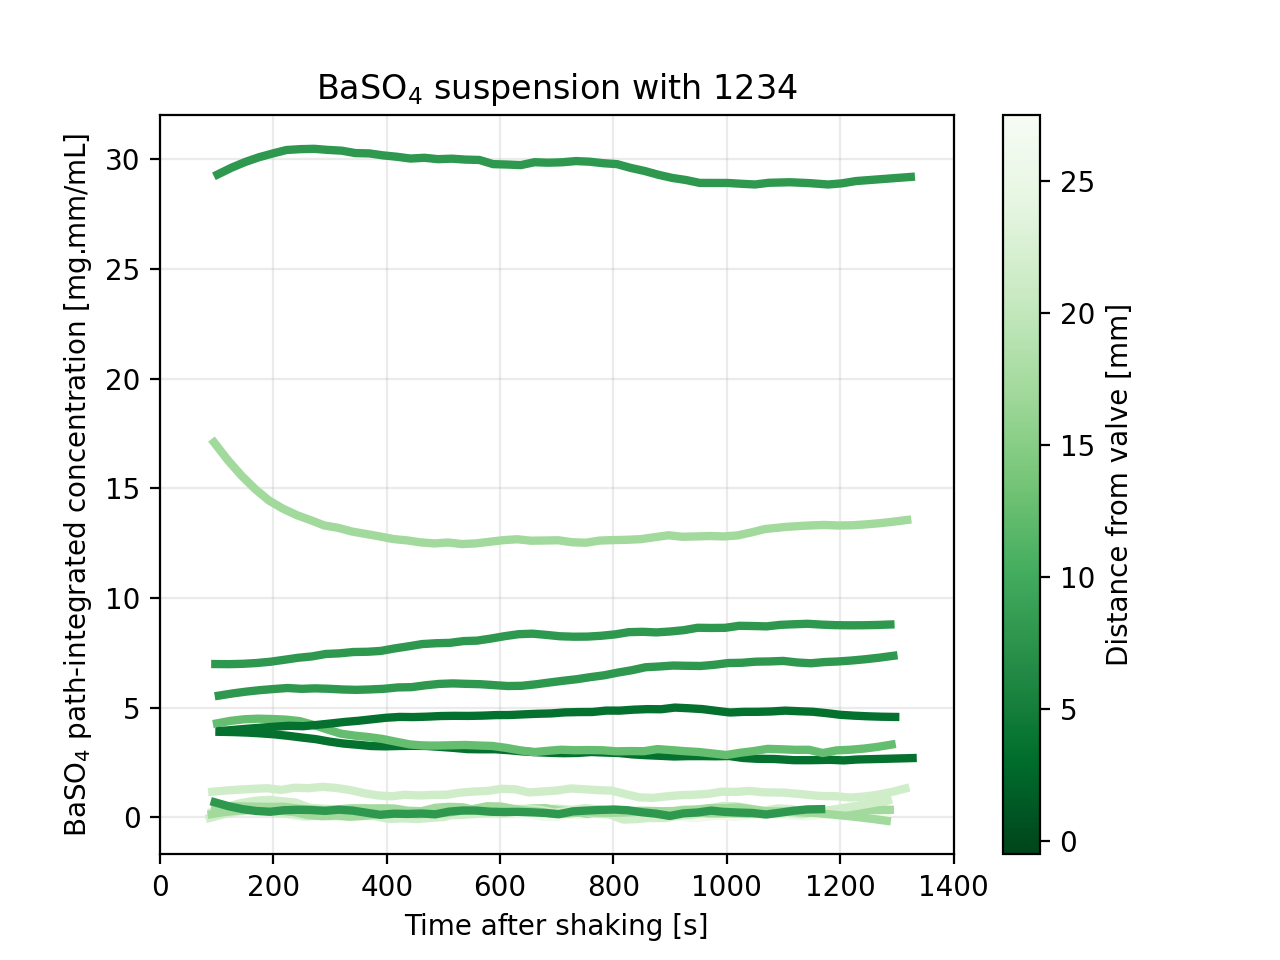

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_81033/4086660134.py:9: RuntimeWarning: Mean of empty slice
  if np.nanmean(z[-5:]) > 1000000: norm = np.nan #offset = 1100


In [538]:
#min,max position values to consider 
selectY = (0,27) 

# Function to apply calibration to data or normalize it
def applyCal(z,calibrationConstant):
    offset=0.
    norm=1.
    # fix anonymously large values (ie scatter off the nozzle wall causes constant offset in signal.)
    if np.nanmean(z[-5:]) > 1000000: norm = np.nan #offset = 1100
    return (z-offset) / calibrationConstant / norm

# Colormap selection based on propellant
def selectcmap(prop):
    if '134' in prop: return plt.cm.Blues_r
    elif '152' in prop: return plt.cm.Oranges_r
    elif '1234' in prop: return plt.cm.Greens_r
    else: raise ValueError("Invalid propellant")

# Colour function
def cfun(x, prop):
    xNorm = (np.median(x) - selectY[0] - 0.5)/(selectY[1]-selectY[0]+0.5*2)
    #xNorm = np.nanmax(x)/255.
    return selectcmap(prop)(xNorm * (xNorm<=1) + (xNorm > 1))
        
# Get all possible Y values.
allY = yTransform(np.concatenate([data[k]['y'].ravel() for k in data if 'VerticalScans' in k]))
print("Y range %f - %f mm\n" % (allY.min(),allY.max()))

# Loop propellants
for prop in ['134','152','1234']:
    
    # Make figure
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.grid(alpha=.25)
    plt.xlabel('Time after shaking [s]')
    plt.ylabel('BaSO$_4$ path-integrated concentration [mg.mm/mL]')
    lList = ['-','--','-.','-','--','-.','-','--','-.']
    plt.title('BaSO$_4$ suspension with %s' % prop)
    # Search all data
    for k in data:
        
        # Show only those which are H scans with correct propellant
        if ('VerticalScans' in k) and (prop in k) and (not '_and_' in k):
            
            # Get data and make label
            t = data[k]['t']
            s = data[k]['shotCounter']
            #x = data[k]['x']
            x = yTransform(data[k]['y']) # modified from horiz.
            prop=data[k]['propellant']
            cc=data[k]['calibrationConstant']
            z = copy.deepcopy(data[k]['fluorCorr']) 
            kk = k.replace('HorizontalScans','').replace('VerticalScans','').replace('Canister','can')
            kk = kk.split('Scan_')[0]
            
            if ((len(t.shape)>1) and (t.shape[0]>1)): # 2D matrix
                flt = np.unique(np.where( (x>=selectY[0])&(x<=selectY[1]) )[1])
                for i in flt:
                    xval = np.median(x[:,i])
                    if ((xval>=selectY[0]) & (xval<=selectY[1])):
                        label = kk+' X=%.2f'% xval
                        if usable(z[:,i],prop):
                            ax.plot(t[:,i], applyCal(smooth(z[:,i]),cc), label=label, c=cfun(xval,prop),lw=lfun(s))

            elif (len(t.shape)==1): # 1D vector
                # Filter on X position
                validX = np.unique(np.round(x[(x>=selectY[0])&(x<=selectY[1])],3))
                for xval in validX:
                    i = validX==xval
                    label = kk+' X=%.2f *'% xval
                    flt = np.where( np.abs(x-xval) < 1e-2 )[0]
                    if(np.any(flt)):
                        if usable(z[flt],prop):
                            ax.plot(t[flt],applyCal(smooth(z[flt]),cc),label=label, c=cfun(xval,prop),lw=lfun(s))

            else:
                raise RuntimeError(k)

    # Make colorbar.
    #if '134' in prop: cmap = plt.cm.Blues
    #elif '152' in prop: cmap = plt.cm.Oranges
    #elif '1234' in prop: cmap = plt.cm.Greens
    vmin = (selectY[0] - 0.5)
    vmax = (selectY[1] + 0.5)
    #sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin=-vmax,vmax=-vmin))
    sm = plt.cm.ScalarMappable(cmap=selectcmap(prop),norm=plt.Normalize(vmin=vmin,vmax=vmax))
    plt.colorbar(sm,ax=ax,label='Distance from valve [mm]')            
    
    #ax.legend(fontsize=8);
    plt.xlim(0,1400)
        